# -- START: Techical Requirements --

In [1]:
import matplotlib 
import pandas as pd
import scipy 
import statsmodels

print(f'''
Matplotlib -> {matplotlib.__version__}
pandas -> {pd.__version__}   
scipy -> {scipy.__version__}
statsmodels -> {statsmodels.__version__}
''')


Matplotlib -> 3.5.1
pandas -> 1.4.1   
scipy -> 1.5.4
statsmodels -> 0.13.2



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


import warnings


warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [16, 3]

### Create DataFrames 

In [3]:
file = Path("../../datasets/Ch8/nyc_taxi.csv")

nyc_taxi = pd.read_csv(file, 
                     index_col='timestamp', 
                     parse_dates=True)

In [4]:
def plot_outliers(outliers, data, method='KNN',
                 halignment = 'right', 
                 valignment = 'top',
                 labels=False):

    ax = data.plot(alpha=0.6)
    
    if labels:
        for i in outliers['value'].items():
            plt.plot(i[0], i[1], 'v', markersize=8, markerfacecolor='none', markeredgecolor='k')
            plt.text(i[0], i[1]-(i[1]*0.04), f'{i[0].strftime("%m/%d")}', 
                         horizontalalignment=halignment,
                         verticalalignment=valignment)
    else:
        data.loc[outliers.index].plot(ax=ax, style='rx')
        
    plt.title(f'NYC Taxi - {method}')
    plt.xlabel('date'); plt.ylabel('# of passengers')
    plt.legend(['nyc taxi','outliers'])
    plt.show()

In [5]:
nyc_dates =  [
        "2014-11-01",
        "2014-11-27",
        "2014-12-25",
        "2015-01-01",
        "2015-01-27"
]
tx = nyc_taxi.resample('D').mean()
known_outliers = tx.loc[nyc_dates]

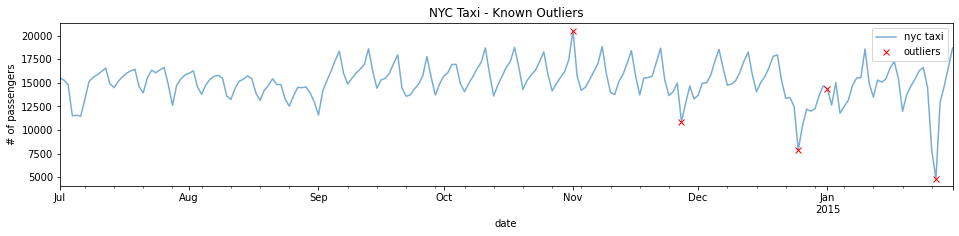

In [6]:
plot_outliers(known_outliers, tx, 'Known Outliers', labels=False)

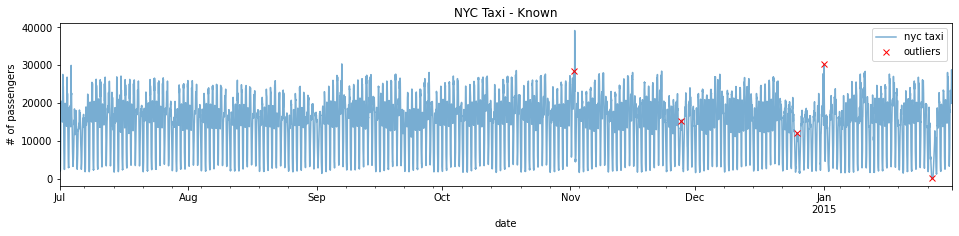

In [7]:
dt = [
        "2014-11-01 19:00:00.000000",
        "2014-11-27 15:30:00.000000",
        "2014-12-25 15:00:00.000000",
        "2015-01-01 01:00:00.000000",
        "2015-01-27 00:00:00.000000"
    ]
kout = nyc_taxi.loc[dt]
plot_outliers(kout, nyc_taxi, 'Known')

# Detecting Outliers with PyCaret

In [42]:
from pycaret.anomaly import *
setup = setup(tx, session_id = 1, normalize=True)

,Description,Value
0,session_id,1
1,Original Data,"(215, 1)"
2,Missing Values,0
3,Numeric Features,1
4,Categorical Features,0
5,Ordinal Features,0
6,High Cardinality Features,0
7,High Cardinality Method,None
8,Transformed Data,"(215, 1)"
9,CPU Jobs,-1


In [9]:
models()

,Name,Reference
ID,,
abod,Angle-base Outlier Detection,pyod.models.abod.ABOD
cluster,Clustering-Based Local Outlier,pyod.models.cblof.CBLOF
cof,Connectivity-Based Local Outlier,pyod.models.cof.COF
iforest,Isolation Forest,pyod.models.iforest.IForest
histogram,Histogram-based Outlier Detection,pyod.models.hbos.HBOS
knn,K-Nearest Neighbors Detector,pyod.models.knn.KNN
lof,Local Outlier Factor,pyod.models.lof.LOF
svm,One-class SVM detector,pyod.models.ocsvm.OCSVM
pca,Principal Component Analysis,pyod.models.pca.PCA


In [10]:
list_of_models = models().index.tolist()[0:8]
list_of_models

['abod', 'cluster', 'cof', 'iforest', 'histogram', 'knn', 'lof', 'svm']

In [37]:
results = {}
for model in list_of_models:
    cols = ['value', 'Anomaly_Score']
    outlier_model = create_model(model, fraction=0.03)
    print(outlier_model)
    outliers = predict_model(outlier_model, data=tx)
    outliers = outliers[outliers['Anomaly'] == 1][cols]
    outliers.sort_values('Anomaly_Score', ascending=False, inplace=True)
    results[model] = {'data': outliers, 'model': outlier_model}

OCSVM(cache_size=200, coef0=0.0, contamination=0.03, degree=3, gamma='auto',
   kernel='rbf', max_iter=-1, nu=0.5, shrinking=True, tol=0.001,
   verbose=False)


In [38]:
results.keys()

dict_keys(['abod', 'cluster', 'cof', 'iforest', 'histogram', 'knn', 'lof', 'svm'])

In [41]:
for model in results:
    print(f'Model: {model}')
    print(results[model]['data'], '\n')

Model: abod
                   value  Anomaly_Score
timestamp                              
2014-11-01  20553.500000      -0.002301
2015-01-27   4834.541667      -0.007914
2014-12-26  10397.958333      -3.417724
2015-01-26   7818.979167    -116.341395
2014-12-25   7902.125000    -117.582752
2014-11-27  10899.666667    -122.169590
2014-10-31  17473.354167   -2239.318906 

Model: cluster
                   value  Anomaly_Score
timestamp                              
2015-01-27   4834.541667       3.657992
2015-01-26   7818.979167       2.113955
2014-12-25   7902.125000       2.070939
2014-11-01  20553.500000       0.998279
2014-12-26  10397.958333       0.779688
2014-11-27  10899.666667       0.520122
2014-11-28  12850.854167       0.382981 

Model: cof
                   value  Anomaly_Score
timestamp                              
2015-01-27   4834.541667       3.911957
2015-01-26   7818.979167       3.795352
2014-12-25   7902.125000       3.710671
2014-11-01  20553.500000       3.14485